## This notebook will help you train a raw Point-Cloud GAN.

(Assumes latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib notebook

In [2]:
import sys
sys.path.insert(0, '/home/gy46/')

In [3]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt

from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.neural_net import MODEL_SAVER_ID

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.general_utils import plot_3d_point_cloud
from latent_3d_points.src.tf_utils import reset_tf_graph

from latent_3d_points.src.vanilla_gan import Vanilla_GAN
from latent_3d_points.src.w_gan_gp import W_GAN_GP
from latent_3d_points.src.generators_discriminators import point_cloud_generator,\
mlp_discriminator, leaky_relu

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Use to save Neural-Net check-points etc.
top_out_dir = '../data/'          

# Top-dir of where point-clouds are stored.
top_in_dir = '../data/ShapeNetV1PCOutput/'


n_pc_points = 2048                # Number of points per model.
# class_name = 'chair'
class_name = 'airplane'

experiment_name = 'raw_gan_with_w_gan_loss_%s'%class_name
print(experiment_name)

raw_gan_with_w_gan_loss_airplane


In [6]:
# Load point-clouds.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id, 'train')
print(class_dir)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.npy', verbose=True)
all_pc_data.point_clouds = all_pc_data.point_clouds[:,:n_pc_points, :]
print('Shape of DATA =', all_pc_data.point_clouds.shape)

../data/ShapeNetV1PCOutput/02691156/train
2832 pclouds were loaded. They belong in 1 shape-classes.
('Shape of DATA =', (2832, 2048, 3))


Set GAN parameters.

In [7]:
use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 500       # Epochs to train.

plot_train_curve = True
save_gan_model = True
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 100)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = all_pc_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
beta = 0.5 # ADAM's momentum.

n_out = [n_pc_points, 3] # Dimensionality of generated samples.


discriminator = mlp_discriminator
generator = point_cloud_generator

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/raw_gan', experiment_name)
    create_dir(train_dir)

In [8]:
reset_tf_graph()

if use_wgan:
    lam = 10
    disc_kwargs = {'b_norm': False}
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,
                    discriminator, generator,
                    disc_kwargs=disc_kwargs, beta=beta)
    
else:    
    leak = 0.2
    disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                      discriminator, generator, beta=beta, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


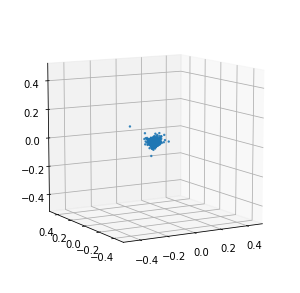

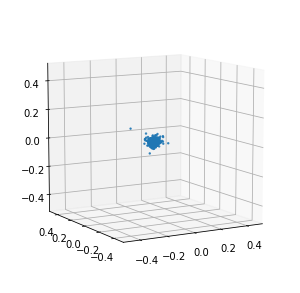

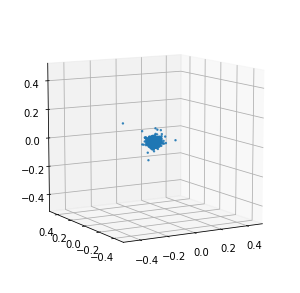

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


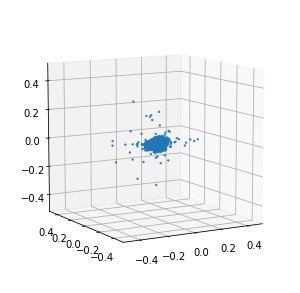

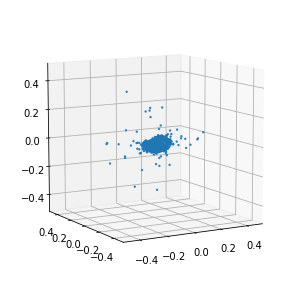

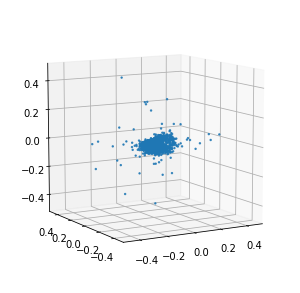

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


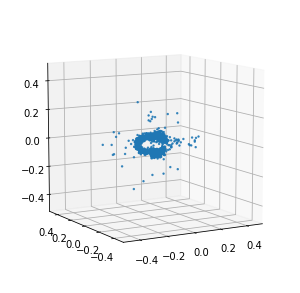

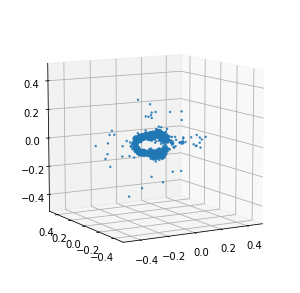

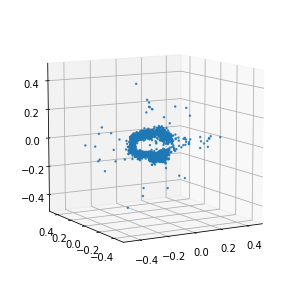

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


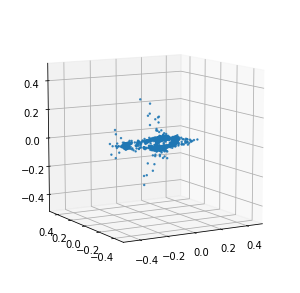

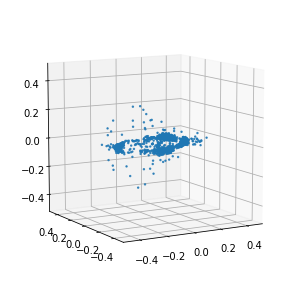

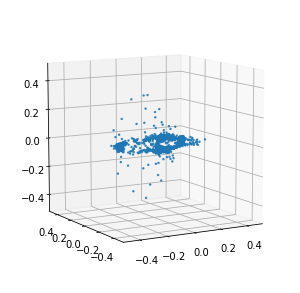

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


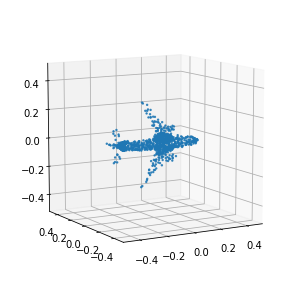

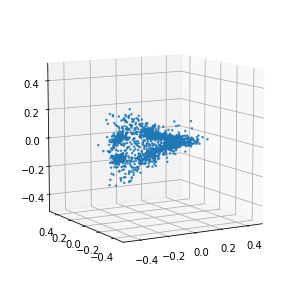

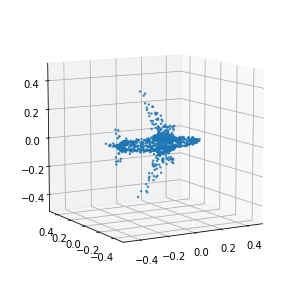

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


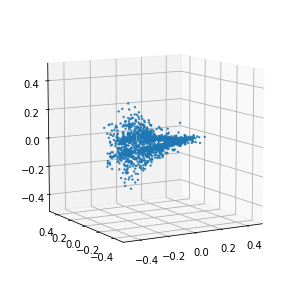

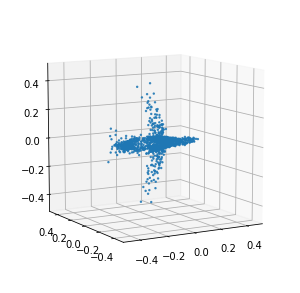

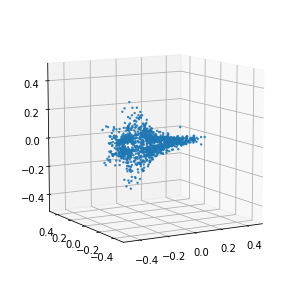

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.


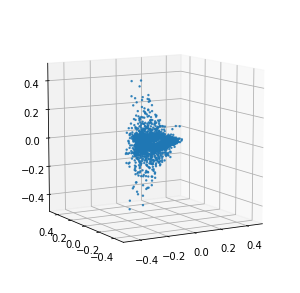

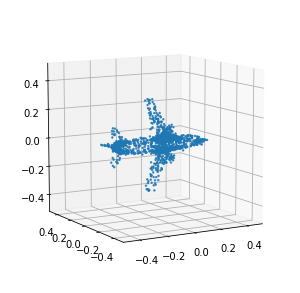

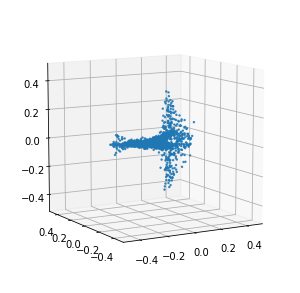

INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_w_gan_loss_airplane/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.


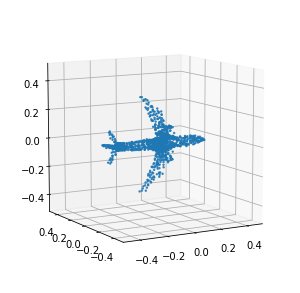

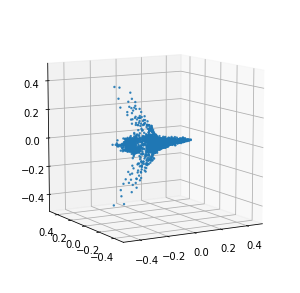

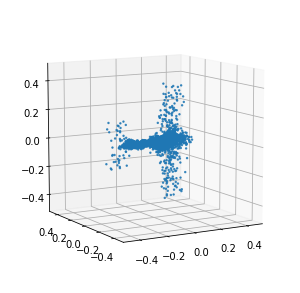

In [9]:
# Train the GAN.
# import tqdm 
from tqdm import tqdm_notebook as tqdm
for _ in tqdm(range(n_epochs)):
    loss, duration = gan._single_epoch_train(all_pc_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.increment_epoch))
#     print epoch, loss

    if save_gan_model and epoch in saver_step:
        checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)

    if save_synthetic_samples and epoch in saver_step:
        syn_data = gan.generate(n_syn_samples, noise_params)
        np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
        for k in range(3):  # plot three (synthetic) random examples.
            plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],
                               in_u_sphere=True)

    train_stats.append((epoch, ) + loss)

/home/gy46/anaconda3/envs/tfpy2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


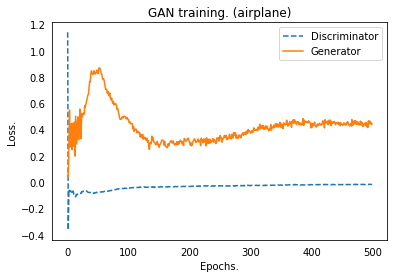

In [10]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('GAN training. (%s)' %(class_name))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

# Evaluation

In [11]:
from latent_3d_points.src.evaluation_metrics import minimum_mathing_distance as MMD
from latent_3d_points.src.evaluation_metrics import jsd_between_point_cloud_sets as JSD
from latent_3d_points.src.evaluation_metrics import coverage as COV


In [12]:
# top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.
top_in_dir = '../data/ShapeNetV1PCOutput/' # Top-dir of where point-clouds are stored.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id, 'val')
# all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.npy', verbose=True)



405 pclouds were loaded. They belong in 1 shape-classes.


In [13]:
feed_pc, _, _ = all_pc_data.full_epoch_data()
feed_pc_tr = feed_pc[:, :n_pc_points]
feed_pc_te = feed_pc[:, -n_pc_points:]
feed_pc_tr.shape, feed_pc_te.shape

((405, 2048, 3), (405, 2048, 3))

In [15]:
syn_data = gan.generate(feed_pc_tr.shape[0], noise_params)
syn_data.shape

(405, 2048, 3)

In [16]:
mmd_emd, _ = MMD(syn_data, feed_pc_te, 200, use_EMD=True, verbose=True)
mmd_emd

0
50
100
150
200
250
300
350
400


0.070122115

In [17]:
mmd_cd, _ = MMD(syn_data, feed_pc_te, 200, use_EMD=False, verbose=True)
mmd_cd

0
50
100
150
200
250
300
350
400


0.0002259857

In [22]:
cov_emd, _ = COV(syn_data, feed_pc_te, 200, use_EMD=True, verbose=True)
cov_emd

0
50
100
150
200
250
300
350
400


0.09135802469135802

In [23]:
cov_cd, _ = COV(syn_data, feed_pc_te, 200, use_EMD=False, verbose=True)
cov_cd

0
50
100
150
200
250
300
350
400


0.32839506172839505

In [24]:
jsd = JSD(syn_data, feed_pc_te)
jsd

0.15027527975902366

In [ ]:
class_name